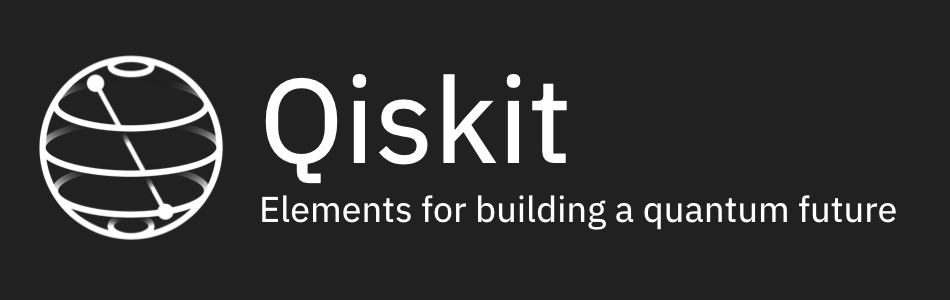

# Qiskit Aqua: Comparison of Amplitude Estimation

### Introduction

The goal of quantum amplitude estimation (AE) is to find an estimate for the amplitude $a \in [0,1]$ defined through an operator $\mathcal A$ via

$$
\mathcal A |0\rangle_n |0\rangle = \sqrt{1 - a} |\psi_0\rangle_n |0\rangle + \sqrt{a} |\psi_1\rangle_n |1\rangle,
$$

where $\psi_0$ and $\psi_1$ are normalized, not necessarily orthogonal, states.
This problem, along with an algorithm to approximate $a$, has been introduced in [[1]](https://arxiv.org/abs/quant-ph/0005055). 
Recently, several variants of the original AE algorithms have been developed to improve the accuracy and reduce the required width and depth of quantum circuits [[2](https://arxiv.org/abs/1912.05559), [3](https://arxiv.org/abs/1904.10246), [4](https://arxiv.org/abs/1908.10846)].

This notebooks compares the performance of these algorithms, which are a part of Qiskit (except [[4]](https://arxiv.org/abs/1908.10846)).

### Problem setting

As in the [introductory notebook on AE](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/aqua/amplitude_estimation.ipynb) we illustrate the algorithms with estimating the probability $p$ underlying a Bernoulli distribution,

$$
\mathcal A |0\rangle = \sqrt{1 - p}|0\rangle + \sqrt{p}|1\rangle = \text{Ry}(\theta_p)|0\rangle,
$$

where $\theta_p = \arcsin^{-1}(\sqrt{p})$.
The AE algorithms use the Grover operator $\mathcal Q = -\mathcal A \mathcal S_0 \mathcal A^{-1} \mathcal S_{\psi_0}$, where $\mathcal S_0$ is a reflection about the zero state and $\mathcal S_{\psi_0}$ about $\psi_0$. In the case of the Bernoulli problem, the $\mathcal Q$ operator, and its powers, simplify to

$$
\mathcal Q^k = \text{Ry}(2k\theta_p).
$$

The following classes implement the $\mathcal A$ and $\mathcal Q$ operator for a probability of $p = 0.3$. Note, that in a realistic example it is the other way around: The $\mathcal A$ operator is provided and we try to estimate the unknown amplitude $a$.

In [1]:
import numpy as np

# the probability to be recovered
probability = 0.3
theta_p = 2*np.arcsin(np.sqrt(probability))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_bloch_vector
from qiskit import BasicAer
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.algorithms.single_sample.amplitude_estimation.q_factory import QFactory
from qiskit.aqua.components.uncertainty_problems import UncertaintyProblem

In [3]:
class BernoulliAFactory(UncertaintyProblem):
    """
    Circuit Factory representing the operator A.
    A is used to initialize the state as well as to construct Q.
    """
    
    def __init__(self, probability=0.5):
        super().__init__(1)
        self._probability = probability
        self.i_state = 0
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
    
    def build(self, qc, q, q_ancillas=None):
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(self._theta_p, q[self.i_state])


class BernoulliQFactory(QFactory):
    """
    Circuit Factory representing the operator Q.
    This implementation exploits the fact that powers of Q can be implemented efficiently by just multiplying the angle.
    (amplitude estimation only requires controlled powers of Q, thus, only this method is overridden.)
    """
    
    def __init__(self, bernoulli_expected_value):
        super().__init__(bernoulli_expected_value, i_objective=0)
    
    def build(self, qc, q, q_ancillas=None):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        # Q is a rotation of angle 2*theta_p around the Y-axis
        qc.ry(2 * theta_p, q[i_state])
        
    def build_power(self, qc, q, power, q_ancillas=None):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        qc.ry(2 * power * theta_p, q[i_state])
    
    def build_controlled_power(self, qc, q, q_control, power, q_ancillas=None, use_basis_gates=True):
        i_state = self.a_factory.i_state
        theta_p = self.a_factory._theta_p
        qc.cry(2 * power * theta_p, q_control, q[i_state])

In [4]:
# construct factories for A and Q
bernoulli_a_factory = BernoulliAFactory(probability)
bernoulli_q_factory = BernoulliQFactory(bernoulli_a_factory)

In [5]:
backend = BasicAer.get_backend('qasm_simulator')
# backend = BasicAer.get_backend('statevector_simulator')

### (Canonical) Amplitude Estimation

The original AE algorithm, which we call canonical AE, was introduced in [[1]](https://arxiv.org/abs/quant-ph/0005055) and uses quantum phase estimation on $m$ controlled powers of $\mathcal Q$ to find an estimate $\tilde a$ for $a$. 
This estimate is restricted to the grid 

$$
    \mathcal G = \left\{\sin^2\left(\frac{y\pi}{2^m}\right) : y = 0, \dots, 2^{m-1} \right\}.
$$

However, using a maximum likelihood estimation (MLE) postprocessing it's possible to remove this grid constraint. This is presented in [[2]](https://arxiv.org/abs/1912.05559).

#### Accuracy

The error of AE scales as

$$
|\tilde a - a| \leq 2\pi\frac{\sqrt{a(1-a)}}{2^m} + \left(\frac{\pi}{2^m}\right)^2,
$$

where $m$ is the number of ancilla qubits, whcih controls the accuracy.
This is a probabilistic error bound, which in practice can be tuned arbitrarily close to 1 using an increasing number of shots and the median of all estimates.
co
Note that the circuit width scales linearly with $m$ and depth exponentially with $\mathcal O(2^m)$ in the number of $\mathcal A$ operators.

The algorithm is implemented as `AmplitudeEstimation` in Qiskit.

In [6]:
from qiskit.aqua.algorithms import AmplitudeEstimation

As a test case, let's run AE with $m=3$ ancilla qubits and with the Bernoulli $\mathcal A$ operator and $\mathcal Q$ operators.

In [7]:
# set number of evaluation qubits
m = 3

# construct amplitude estimation
# here, we override the standard construction of Q since we know a more efficient way
# (exploiting the fact that A and Q are just Y-rotations)
ae = AmplitudeEstimation(m)
ae.a_factory = bernoulli_a_factory
ae.q_factory = bernoulli_q_factory

In [8]:
result = ae.run(backend)

The estimate $\tilde a$ restricted to the grid is

In [9]:
print(result['estimation'])

0.1464466


We also have access to the MLE, using the key `'mle'`

In [10]:
print(result['mle'])

0.3014273102111584


The circuit executed `shot` times for AE (lacking the measurments) is presented below.

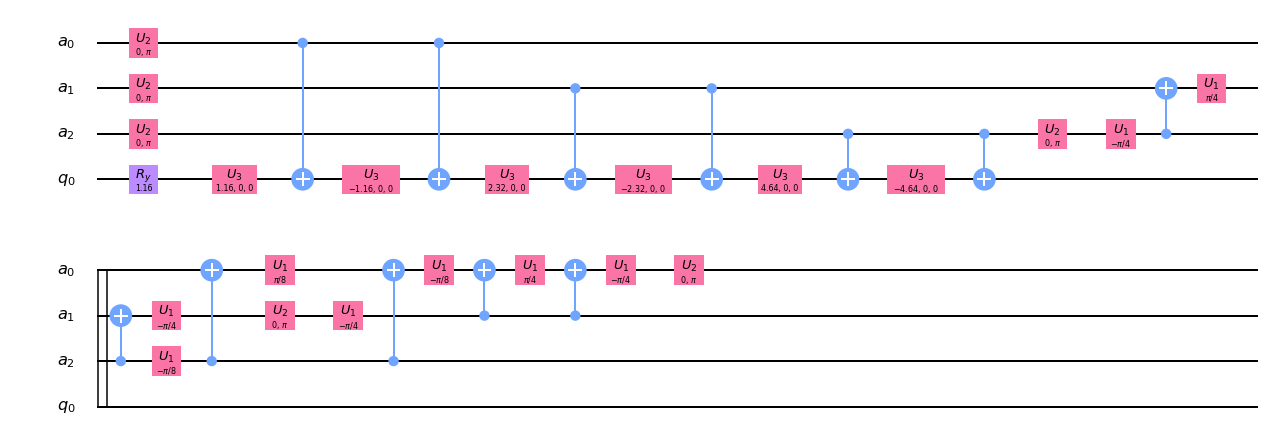

In [11]:
ae.construct_circuit().draw(output='mpl')

Without the efficient implementation of the $\mathcal Q$ operator, which is the more general case, the circuit is more complex.

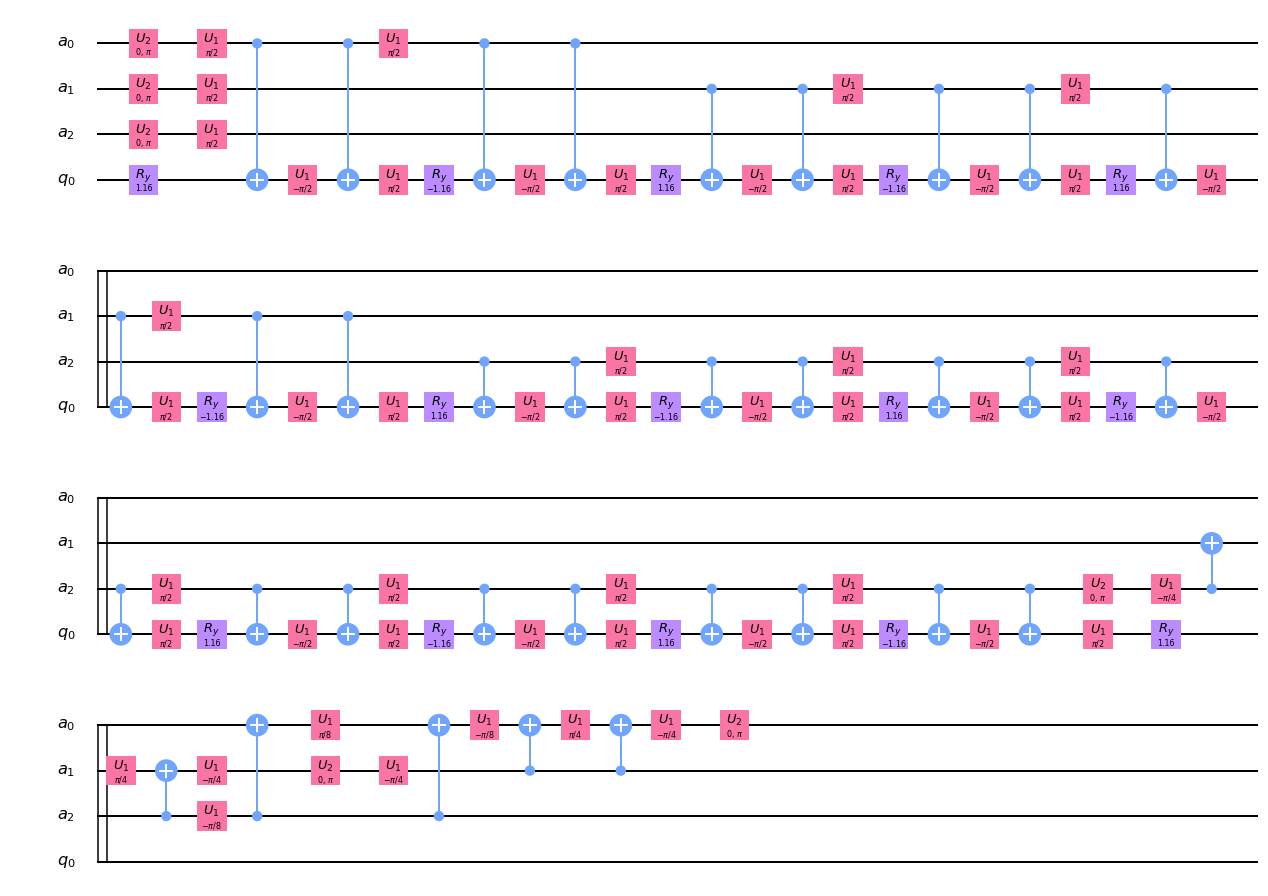

In [12]:
ae.q_factory = None
ae.construct_circuit().draw(output='mpl')

### Iterative Amplitude Estimation

Iterative quantum amplitude estimation (IQAE) has been introduced in [[2]](https://arxiv.org/abs/1912.05559).
The key idea of the algorithm is to iteratively measure $\mathcal Q^k \mathcal A |0\rangle_n |0\rangle$ for increasing powers $k$ of $\mathcal Q$.
The probability to measure the state $|1\rangle$ in the last qubit is

$$
    p = \sin^2((2k + 1)\theta) = \frac{1 - \cos(2(2k + 1)\theta)}{2},
$$

and by inverting the probability $p$, we obtain an estimate for $\theta$. To improve the estimate, which has only a finite resolution since we use a finite number of shots to estimate $p$, we repeat the procedure with a higher power $k$. This allows us to estimate the bits of less significance as before, as the estimate is done modulo $2\pi$.
The difficulty of the algorithm lies in determining the suitable sequence of powers $k_i$, which is discussed in detail in [[2]](https://arxiv.org/abs/1912.05559). 

In a nutshell:
Given that the current estimate of $\theta$ is in $[\theta^{min}_i,\theta^{max}_i]$. Then we need to find the largest integer $k_{i+1}$ such that 

$$
    \frac{2k_{i+1} + 1}{2k_i + 1} \cdot [\theta^{min}_i,\theta^{max}_i]  \in [0, \pi] \vee [\pi, 2\pi], ~~ (\text{mod } 2\pi)  
$$

i.e., the scaled confidence interval lies fully in the bottom or top halfplane. Then the value of $(2k_{i+1} + 1)\theta$ can unambiguously be estimated from $p$ and knowledge of the location of the previous interval $[\theta^{min}_i,\theta^{max}_i]$. With this new estimate we can refine our confidence interval.


#### Advantages

Unlike the original AE algorithm, IQAE doesn't require a phase estimation. For an increasing accuracy, the circuit width stays the same and only the circuit depth and calls to the operator $\mathcal A$ increase.
Also, as stated in [[2]](https://arxiv.org/abs/1912.05559) this formulation requires the least amount of oracle calls in comparison to the other (currently) known variants of AE.

Since it's iterative however, the circuits cannot be executed in parallel, unlike in [[3]](https://arxiv.org/abs/1904.10246).

#### Accuracy

The desired accuracy of IQAE can be directly set as input of the algorithm, which is another advantage. The output is an estimate, that with probability at least $1 - \alpha$ the error is at most $\epsilon$, where both $\alpha$ and $\epsilon$ can be specified in the input.

In [13]:
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation

In [14]:
# set target accuracy and alpha level for the confidence interval
epsilon, alpha = 0.01, 0.05

In [15]:
iae = IterativeAmplitudeEstimation(epsilon, alpha)
iae.a_factory = bernoulli_a_factory
iae.q_factory = bernoulli_q_factory
result = iae.run(backend)

In [16]:
print('estimate:', result['estimation'])
confidence_level = 100 * (1 - result['alpha'])
print('{}% confidence interval'.format(confidence_level), result['confidence_interval'])

estimate: 0.29945221445115955
95.0% confidence interval [0.2951195269463853, 0.3037849019559337]


Let's look at the circuit the algorithm constructs. Note, that we use the efficient $\mathcal Q$ implementation here.

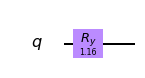

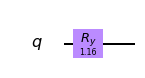

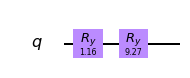

In [17]:
for k in result['powers']:
    ax = plt.axes()
    iae.construct_circuit(k).draw(output='mpl', ax=ax)
    plt.show()

Without the efficient $\mathcal Q$ operator, we obtain a longer circuit. But comparing to the original AE circuit, this is a much, much simpler one!

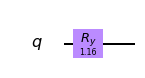

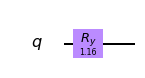

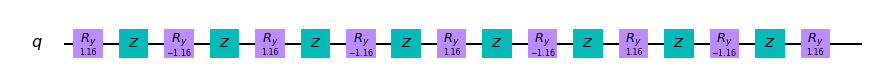

In [18]:
iae.q_factory = None
for k in result['powers']:
    ax = plt.axes()
    iae.construct_circuit(k).draw(output='mpl', ax=ax)
    plt.show()

### Maximum Likelihood Amplitude Estimation

In [[3]](https://arxiv.org/abs/1904.10246) another variant of AE is presented (named AE without phase estimation). The idea is to measure the probability $p = \sin^2((2k + 1)\theta)$ for different powers $k$ and perform a maxmimum likelihood estimation to obtain an estimate for $\theta$, and thus, for $a$. For a specified largest power $k_\max$ of $\mathcal Q$, the algorithm executes the circuits $\{\mathcal Q^j \mathcal A |0\rangle_n |0\rangle : j = 0, 2^0, 2^1, \dots, 2^{k_\max}\}$.

#### Advantages

As IQAE, no ancilla qubits are required, which reduces the circuit width in comparison to canonical AE. A further advantage is, that the different powers of $\mathcal Q$ can be run in parallel circuits. 

#### Accuracy

The accuracy can be improved by increasing $k_\max$. A lower error bound is provided in [[3]](https://arxiv.org/abs/1904.10246).

In [19]:
from qiskit.aqua.algorithms import MaximumLikelihoodAmplitudeEstimation

In [20]:
log_max_evals = 3

In [21]:
mlae = MaximumLikelihoodAmplitudeEstimation(log_max_evals)
mlae.a_factory = bernoulli_a_factory
mlae.q_factory = bernoulli_q_factory

result = mlae.run(backend)

In [22]:
print('estimation:', result['estimation'])
print('95% confidence interval:', result['95%_confidence_interval'])

estimation: 0.29986865322922723
95% confidence interval: [0.2972516486147726, 0.30248565784368187]


With the efficient Bernoulli $\mathcal Q$ operator the circuits are...

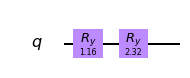

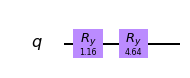

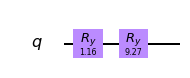

In [23]:
for circuit in mlae.construct_circuits():
    ax = plt.axes()
    circuit.draw(output='mpl', ax=ax)
    plt.show()

and with the default implementation of $\mathcal Q$...

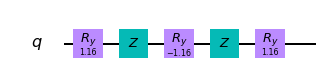

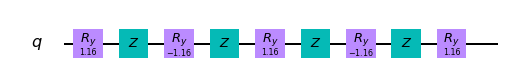

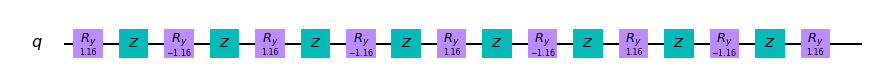

In [24]:
mlae.q_factory = None
for circuit in mlae.construct_circuits():
    ax = plt.axes()
    circuit.draw(output='mpl', ax=ax)
    plt.show()

---
_SKIPPED_

### Amplitude Estimation, Simplified

* this comes from that paper
* it does this and that
* currently not integrated in qiskit since too large constants
* accuracy scaled by
---

### Performance comparison

In the following section we investigate the perfomances of the above variants of AE. 
As a measure of performance we compare the achieved estimation accuracy, measured as half the width of the 95% confidence interval, against the total number of applications of the $\mathcal A$ operator. (Each shot counts as one application.)

We store the results in the `convergence` dictionary.

In [25]:
convergence = {}
shots = 100

_Amplitude Estimation_ Since the accuracy of QAE scales with the number of ancilla qubits $m$, we run the algorithm for different values of $m$. The confidence intervals are computed with the likelihood ratio, since they are they produce the most reliable intervals. 
The number of applications of the $\mathcal A$ operator per shot is

$$
    \frac{N_\text{oracle}}{N_\text{shots}} = 1 + 2 \cdot 2^0 + 2 \cdot 2^1 + \dots + 2 \cdot 2^{m - 1} = 2^0 + 2^1 + \dots + 2^m = 2^{m+1} - 1,
$$

since the $\mathcal A$ operator is applied once at the beginning of the circuit, followed by the powers $2^i, i = 0, \dots, m-1$ of $\mathcal Q$, which contains 2 applications of $\mathcal A$. Hence, the number of operator queries is

$$
    N_\text{oracle} = N_\text{shots} (2^{m+1} - 1).
$$

Let's set the values of ancilla qubits first.

In [26]:
# with Aer's qasm simulator and the Bernoulli factories we can compute high accuracies
# note, that for the statevector simulator (or more difficult A operators) we need to choose smaller m
if backend.configuration().backend_name == 'qasm_simulator':
    m_max = 25 
    m_values = list(range(2, m_max, 3))
else:
    m_max = 10
    m_values = list(range(2, m_max))  

For the evaluation we store the number of operator applications (or oracle calls) and the maximal error we have with at least 95% probability, i.e. half the width of the 95% confidence interval.

In [27]:
convergence['ae'] = {'num_oracle_calls': [], '95%_epsilon': []}

for m in m_values:
    ae = AmplitudeEstimation(m, a_factory=bernoulli_a_factory, q_factory=bernoulli_q_factory)
    result = ae.run(backend, shots=shots)
    num_oracle_calls = shots * (2**(m + 1) - 1)
    
    convergence['ae']['num_oracle_calls'] += [num_oracle_calls]
    convergence['ae']['95%_epsilon'] += [np.diff(result['95%_confidence_interval'])[0] / 2]

_Iterative Amplitude Estimation_ For IQAE we set simply have to set the desired target accuracies. The number of oracle calls is determined dynamically and we cannot exactly precompute it. The value of $N_\text{oracle}$ is returned as part of the result of the algorithm.

For the computation of the confidence interval, we set the confidence level to $1 - \alpha = 0.95$ and rely on the Clopper-Pearson confidence interval used in within IQAE.

In [28]:
epsilon_values = 10.0**(-np.arange(1, 9))

In [29]:
convergence['iae'] = {'num_oracle_calls': [], '95%_epsilon': []}

alpha = 0.05
for epsilon in epsilon_values:
    iae = IterativeAmplitudeEstimation(epsilon, alpha, a_factory=bernoulli_a_factory, q_factory=bernoulli_q_factory)
    result = iae.run(backend, shots=shots)
    
    convergence['iae']['num_oracle_calls'] += [result['num_oracle_queries']]
    convergence['iae']['95%_epsilon'] += [np.diff(result['confidence_interval'])[0] / 2]

_Maximum Likelihood Amplitude Estimation_ The accuracy of MLAE is governed by the maximum power of the $\mathcal Q$ operator, we call `log_max_evals` since the largest power is a power of 2, i.e. $2^\texttt{log_max_evals}$.

Before running this algorithm for high accuracies we inspect the shape of the loglikelihood function $\ell$, whose maximum is the output of the algorithm. It turns out, that $\ell$ quickly becomes highly oscillating. Such a shape is difficult for numerical optimizers, without exact knowledge about the structure. 

In [30]:
def plot_mlae_loglikelihood(log_max_evals, nevals=10000):
    mlae = MaximumLikelihoodAmplitudeEstimation(log_max_evals, a_factory=bernoulli_a_factory, 
                                                q_factory=bernoulli_q_factory)
    _ = mlae.run(backend, shots=shots)
    
    def loglikelihood(theta, one_counts, all_counts):
            logL = 0
            for i, k in enumerate(mlae._evaluation_schedule):
                logL += np.log(np.sin((2 * k + 1) * theta) ** 2) * one_counts[i]
                logL += np.log(np.cos((2 * k + 1) * theta) ** 2) * (all_counts[i] - one_counts[i])
            return logL

    one_counts, all_counts = mlae._get_hits()

    thetas = np.linspace(np.pi / nevals / 2, np.pi / 2, nevals)
    values = np.zeros(len(thetas))
    for i, t in enumerate(thetas):
        values[i] = loglikelihood(t, one_counts, all_counts)
        
    plt.plot(thetas, values, label='powers up to $2^{{{}}}$'.format(log_max_evals - 1))
    plt.ylim(bottom=-3000, top=0)

Let's visualize $\ell$ up to powers 3 and 8 of $\mathcal Q$.

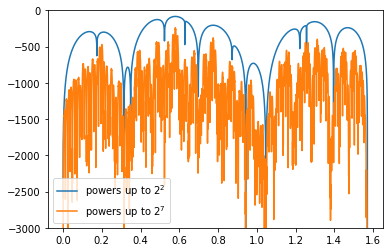

In [31]:
plot_mlae_loglikelihood(3)
plot_mlae_loglikelihood(8)
plt.legend(loc='best')

Ideas to search the maximum of the loglikelihood functions exist and are based on iteratively finding the maximum for low powers of $\mathcal Q$ and restricting the search interval based on the Fisher information in each step.
However, currently no stable implementation exists and we have to rely on a brute force maximum search by evaluating the loglikelihood on a fine grid and taking the global maximum. 
The width of the peaks is approximately of order $\mathcal O(2^{-\texttt{log_max_evals}})$, thus to reliably find the maximum we choose a gridsize of $\delta 2^{-\texttt{log_max_evals}}$, where $\delta$ determines the accuracy which we set to $\delta = 10^{-4}$. This scales exponentially in the highest power of $\mathcal Q$ we apply, and quickly becomes inefficient to evaluate.

In [32]:
for power in range(2, 20, 5):
    print('highest power of Q:', power, '\tnumber of gridpoints:', int(np.pi / 2 * 10**3 * 2**(power)))

highest power of Q: 2 	number of gridpoints: 6283
highest power of Q: 7 	number of gridpoints: 201061
highest power of Q: 12 	number of gridpoints: 6433981
highest power of Q: 17 	number of gridpoints: 205887416


In comparison, the loglikelihood function of canonical AE has a much easier structure. Additionally, we also have the grid-based AE estimate we can use to find the MLE. The AE estimate is marked as dotted line, to find the MLE we look in the two neighbouring bubble-shaped intervals, which with very high probability contains the exact value. In these two intervals we use a bisection search, which allows us to find the maximum very precisely with constant overhead (in terms of ancilla qubits/power of $\mathcal Q$).

In [33]:
from qiskit.aqua.algorithms.single_sample.amplitude_estimation.ae_utils import pdf_a

def plot_ae_loglikelihood(m, color='tab:blue', nevals=10000):
    ae = AmplitudeEstimation(m, a_factory=bernoulli_a_factory, q_factory=bernoulli_q_factory)
    result = ae.run(backend, shots=shots)
    ai = np.asarray(result['values'])
    pi = np.asarray(result['probabilities'])

    def loglikelihood(a):
        return np.sum(shots * pi * np.log(pdf_a(ai, a, m)))

    a_values = np.linspace(0, 1, nevals)
    values = np.zeros(len(a_values))
    for i, a in enumerate(a_values):
        values[i] = loglikelihood(a)
    
    ae_estimate = result['estimation']
    plt.axvline(ae_estimate, color=color, linestyle=':')
    plt.plot(a_values, values, color=color, label='powers up to $2^{{{}}}$'.format(m - 1))
    plt.ylim(bottom=-3000, top=0)

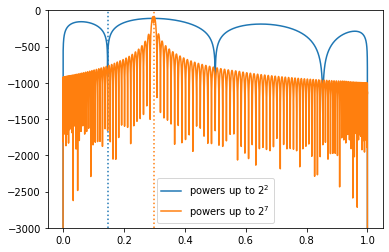

In [34]:
plot_ae_loglikelihood(3, color='tab:blue')
plot_ae_loglikelihood(8, color='tab:orange')
plt.legend(loc='best')

To run this notebook in a reasonable amount of time, we limit the evaluation of the loglikelihood function to a maximum of $10^6$ points, i.e. up to `log_max_evals` = 9.

In [35]:
log_max_evals_values = list(range(2, 10))

In one application of the algorithm, $\mathcal A$ is applied once in the beginning of every executed circuit and twice as part of every $\mathcal Q$ operator. Writing `log_max_evals` = $k_\max$, this is

$$
\frac{N_\text{oracle}^\text{total}}{N_\text{shots}} = k_\max + 2 \cdot 2^0 + 2 \cdot 2^1 + \dots + 2 \cdot 2^{k_\max - 1} = 2^0 + 2^1 + \dots + 2^{k_\max} = 2^{k_\max +1} - 2 + k_\max.
$$

However, since the circuits can be executed in parallel, it makes sense to use the number of $\mathcal A$ applications in the longest circuit as measure of performance. The longest circuit is where the highest power of $\mathcal Q$ is applied, i.e.

$$
\frac{N_\text{oracle}^\text{parallel}}{N_\text{shots}} = 1 + 2 \cdot 2^{k_\max - 1} = 1 + 2^{k_\max}.
$$

As for (canonical) amplitude estimation, the confidence intervals are computed via the likelihood ratio.

In [36]:
convergence['mlae'] = {'num_oracle_calls': [], 'max_serial_oracle_calls': [], '95%_epsilon': []}

for log_max_evals in log_max_evals_values:
    mlae = MaximumLikelihoodAmplitudeEstimation(log_max_evals, a_factory=bernoulli_a_factory, 
                                              q_factory=bernoulli_q_factory)
    result = mlae.run(backend, shots=shots)
    num_oracle_calls = shots * (log_max_evals + 2**(log_max_evals + 1) - 2)
    max_serial_oracle_calls = shots * (1 + 2**(log_max_evals))
    
    convergence['mlae']['num_oracle_calls'] += [num_oracle_calls]
    convergence['mlae']['max_serial_oracle_calls'] += [max_serial_oracle_calls]
    convergence['mlae']['95%_epsilon'] += [np.diff(mlae.confidence_interval(0.05, 'lr'))[0] / 2]

The final results are displayed in the plot below.

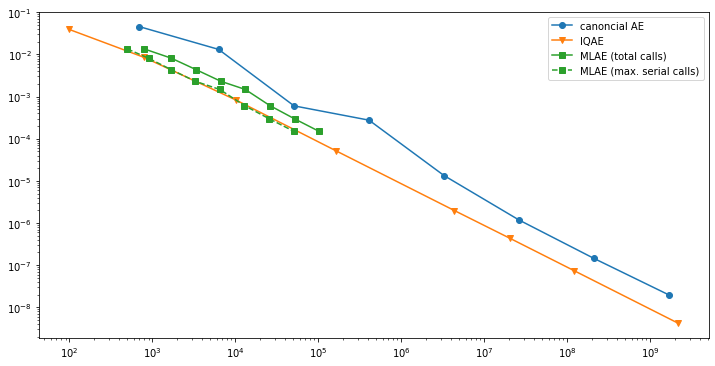

In [37]:
plt.figure(figsize=(12, 6))

plt.loglog(convergence['ae']['num_oracle_calls'], 
           convergence['ae']['95%_epsilon'], 
           marker='o', label='canoncial AE')
plt.loglog(convergence['iae']['num_oracle_calls'], 
           convergence['iae']['95%_epsilon'], 
           marker='v', label='IQAE')
plt.loglog(convergence['mlae']['num_oracle_calls'], 
           convergence['mlae']['95%_epsilon'], 
           marker='s', color='tab:green', label='MLAE (total calls)')
plt.loglog(convergence['mlae']['max_serial_oracle_calls'], 
           convergence['mlae']['95%_epsilon'], 
           marker='s', color='tab:green', linestyle='--', label='MLAE (max. serial calls)')
plt.legend(loc='best')

In [38]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright